In [1]:
import tensorflow as tf
from tensorflow.keras import datasets

In [11]:
import numpy as np
(X_train_full, y_train_full), (X_test, y_test) = datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

In [14]:
stacked_encoder = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[28, 28]),
tf.keras.layers.Dense(100, activation="selu"),
tf.keras.layers.Dense(30, activation="selu"),
])

In [15]:
stacked_decoder = tf.keras.models.Sequential([
tf.keras.layers.Dense(100, activation="selu", input_shape=[30]),
tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
tf.keras.layers.Reshape([28, 28])
])

In [16]:
stacked_ae = tf.keras.models.Sequential([stacked_encoder, stacked_decoder])

In [17]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [18]:
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [19]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9003
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9197
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2982 - val_rounded_accuracy: 0.9206
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [==================

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")

  
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 18ms/step


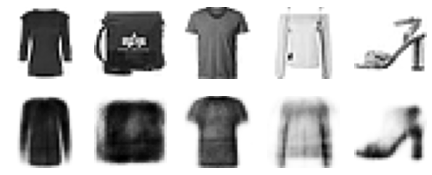

In [28]:
show_reconstructions(stacked_ae)

157/157 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


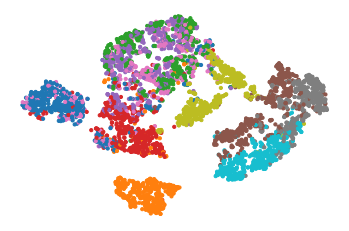

In [29]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [30]:
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

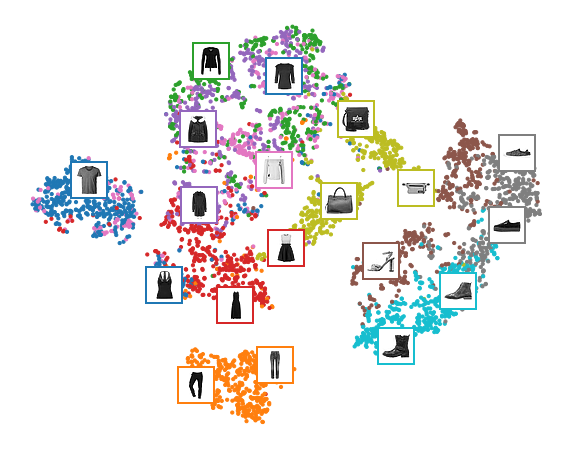

In [31]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

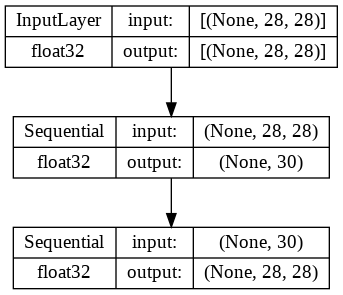

In [35]:
tf.keras.utils.plot_model(
    stacked_ae,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

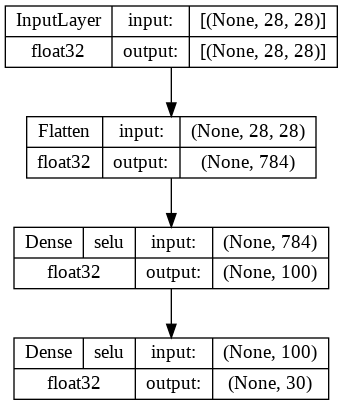

In [37]:
tf.keras.utils.plot_model(
    stacked_encoder,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

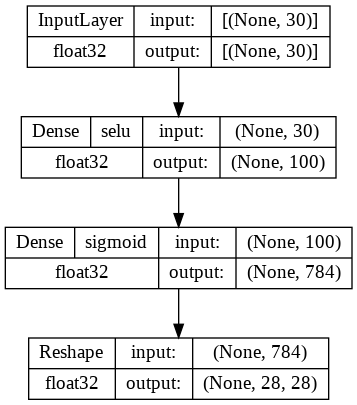

In [38]:
tf.keras.utils.plot_model(
    stacked_decoder,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)